In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [8]:
# データの読み込み
# ここではCSVファイルから1分足データを読み込むと仮定します
# データには'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'の列が含まれているとします
data = pd.read_csv('../data/bybit_ethusdt_20240901-20240930.csv', parse_dates=['Timestamp'])
data.set_index('Timestamp', inplace=True)

In [9]:
# テクニカル指標の計算関数
def SMA(series, period):
    return series.rolling(window=period).mean()

def Bollinger_Bands(series, period=20, std_multiplier=2):
    sma = series.rolling(window=period).mean()
    std = series.rolling(window=period).std()
    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std
    return upper_band, sma, lower_band

def RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [10]:
# パラメータの範囲
sma_short_range = [5, 10, 15]
sma_long_range = [20, 30, 50]
rsi_low_range = [30, 40, 50]
rsi_high_range = [60, 70, 80]
bb_std_range = [1.5, 2, 2.5]

best_sharpe = -np.inf
best_params = None
best_data = None

In [11]:
# グリッドサーチでパラメータ最適化
for sma_short_period, sma_long_period, rsi_low, rsi_high, bb_std in product(sma_short_range, sma_long_range, rsi_low_range, rsi_high_range, bb_std_range):
    df = data.copy()
    
    # 必要な期間のデータを使用
    min_period = max(sma_long_period, 20, 14)
    df = df.iloc[min_period:]
    
    # テクニカル指標の計算
    df['SMA_short'] = SMA(df['Close'], period=sma_short_period)
    df['SMA_long'] = SMA(df['Close'], period=sma_long_period)
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = Bollinger_Bands(df['Close'], period=20, std_multiplier=bb_std)
    df['RSI'] = RSI(df['Close'], period=14)
    
    # シグナルの生成
    df['Signal'] = 0
    df['Position'] = 0
    position = 0
    entry_price = 0
    
    for i in range(1, len(df)):
        # ロングエントリーの条件
        if (df['Close'].iloc[i] < df['BB_lower'].iloc[i]) and (df['RSI'].iloc[i] < rsi_low) and \
           (df['SMA_short'].iloc[i] > df['SMA_long'].iloc[i]) and (df['SMA_short'].iloc[i-1] <= df['SMA_long'].iloc[i-1]) and position == 0:
            df['Signal'].iloc[i] = 1  # 買いシグナル
            position = 1
            entry_price = df['Close'].iloc[i]
        
        # ショートエントリーの条件
        elif (df['Close'].iloc[i] > df['BB_upper'].iloc[i]) and (df['RSI'].iloc[i] > rsi_high) and \
             (df['SMA_short'].iloc[i] < df['SMA_long'].iloc[i]) and (df['SMA_short'].iloc[i-1] >= df['SMA_long'].iloc[i-1]) and position == 0:
            df['Signal'].iloc[i] = -1  # 売りシグナル
            position = -1
            entry_price = df['Close'].iloc[i]
        
        # ポジションのエグジット条件
        if position == 1:
            if (df['Close'].iloc[i] >= df['SMA_long'].iloc[i]) or (df['Close'].iloc[i] <= entry_price * 0.99):
                df['Signal'].iloc[i] = 0  # エグジットシグナル
                position = 0
        elif position == -1:
            if (df['Close'].iloc[i] <= df['SMA_long'].iloc[i]) or (df['Close'].iloc[i] >= entry_price * 1.01):
                df['Signal'].iloc[i] = 0  # エグジットシグナル
                position = 0
        
        df['Position'].iloc[i] = position
    
    # リターンの計算
    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df['Return'] * df['Position'].shift(1)
    
    # パフォーマンスの評価
    total_returns = df['Strategy_Return'].sum()
    annual_returns = df['Strategy_Return'].mean() * 252 * 24 * 60
    annual_std = df['Strategy_Return'].std() * np.sqrt(252 * 24 * 60)
    sharpe_ratio = annual_returns / annual_std if annual_std != 0 else 0
    
    if sharpe_ratio > best_sharpe:
        best_sharpe = sharpe_ratio
        best_params = (sma_short_period, sma_long_period, rsi_low, rsi_high, bb_std)
        best_data = df.copy()

/tmp/ipykernel_194/2135960309.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'].iloc[i] = position
/tmp/ipykernel_194/2135960309.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[i] = -1  # 売りシグナル
/tmp/ipykernel_194/2135960309.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'].iloc[i] = 0  # エグジットシグナル
/tmp/ipykernel_194/2135960309.py:46: SettingWithCopyWarning: 
A value is trying to

In [12]:
print(f"Best Sharpe Ratio: {best_sharpe:.2f}")
print(f"Best Parameters: SMA Short={best_params[0]}, SMA Long={best_params[1]}, RSI Low={best_params[2]}, RSI High={best_params[3]}, BB Std={best_params[4]}")

Best Sharpe Ratio: 4.94
Best Parameters: SMA Short=10, SMA Long=20, RSI Low=30, RSI High=60, BB Std=1.5


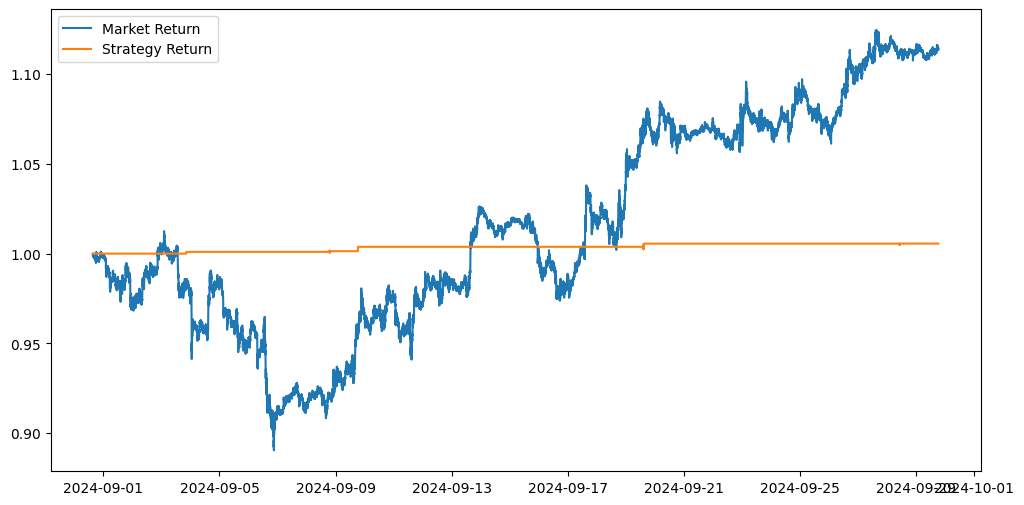

In [13]:
# 最適なパラメータでの結果を表示
best_data['Cumulative_Strategy_Return'] = (1 + best_data['Strategy_Return']).cumprod()
best_data['Cumulative_Market_Return'] = (1 + best_data['Return']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(best_data['Cumulative_Market_Return'], label='Market Return')
plt.plot(best_data['Cumulative_Strategy_Return'], label='Strategy Return')
plt.legend()
plt.show()